In [1]:
import torch
import math
from dataset import SatProblemDataSet
from models import MLP, LayerNormBasicLSTMCell, NeuroSAT
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
def compute_loss(logits, labels, parameters):
    # x = logits, z = labels
    # max(x, 0) - x * z + log(1 + exp(-abs(x)))
    predict_costs = torch.nn.functional.relu(logits) - logits * labels + torch.log1p(torch.exp(-torch.abs(logits)))
    predict_cost = torch.mean(predict_costs)
    l2_cost = torch.zeros([])
    for p in parameters:
        l2_cost += torch.sum(torch.square(p)) / 2
    return predict_cost + 1e-9 * l2_cost

In [3]:
n = NeuroSAT(5, 3, 3, 128)

In [4]:
ds = SatProblemDataSet("data")
dl = torch.utils.data.DataLoader(ds)

In [5]:
optim = torch.optim.Adam(n.parameters(), lr = 1e-5, weight_decay = 1e-10)
n.train()

NeuroSAT(
  (LC_msg): MLP(
    (linears): ModuleList(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): Linear(in_features=5, out_features=5, bias=True)
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): Linear(in_features=5, out_features=5, bias=True)
    )
    (activation_func): ReLU()
  )
  (CL_msg): MLP(
    (linears): ModuleList(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): Linear(in_features=5, out_features=5, bias=True)
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): Linear(in_features=5, out_features=5, bias=True)
    )
    (activation_func): ReLU()
  )
  (L_update): LayerNormBasicLSTMCell(
    (fiou_linear): Linear(in_features=15, out_features=20, bias=False)
    (fiou_ln_layers): ModuleList(
      (0): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
      (1): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
      (2): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
      (3):

In [10]:
losses = []
loss_fn = torch.nn.BCELoss()
for _ in range(1):
    for prob, target in dl:
        optim.zero_grad()
        outputs = n(prob[0].float())
    #     print(outputs, prob[1])
        torch.nn.utils.clip_grad_norm_(n.parameters(), 0.5)
#         loss = compute_loss(outputs, target[0], n.parameters())
        loss = loss_fn(outputs, target[0])
        desc = 'loss: %.4f; ' % (loss.item())
        losses.append(loss.item())
        print(desc)

        loss.backward()
        optim.step()

loss: 0.0003; 
loss: 8.2283; 
loss: 0.0003; 
loss: 8.1418; 
loss: 0.0047; 
loss: 5.4070; 
loss: 0.0048; 
loss: 4.9363; 
loss: 0.0041; 
loss: 6.9209; 
loss: 0.0004; 
loss: 7.7848; 
loss: 0.0016; 
loss: 7.8267; 
loss: 0.0006; 
loss: 7.4033; 
loss: 0.0046; 
loss: 7.5841; 
loss: 0.0149; 
loss: 4.2144; 
loss: 0.0009; 
loss: 7.3179; 
loss: 0.0542; 
loss: 3.1919; 
loss: 0.0004; 
loss: 7.7505; 
loss: 0.0004; 
loss: 7.7395; 
loss: 0.0005; 
loss: 7.5688; 
loss: 0.0836; 
loss: 2.5547; 
loss: 0.0111; 
loss: 4.4827; 
loss: 0.0065; 
loss: 5.0595; 
loss: 0.0006; 
loss: 3.1817; 
loss: 0.0005; 
loss: 7.4968; 
loss: 0.0005; 
loss: 7.5318; 
loss: 0.0028; 
loss: 5.0811; 
loss: 0.0006; 
loss: 7.4368; 
loss: 0.0016; 
loss: 6.2209; 
loss: 0.0103; 
loss: 4.9924; 
loss: 0.0004; 
loss: 7.8025; 
loss: 0.0006; 
loss: 7.4964; 
loss: 0.0005; 
loss: 7.5223; 
loss: 0.0006; 
loss: 7.4228; 
loss: 0.0016; 
loss: 6.4179; 
loss: 0.0087; 
loss: 4.8971; 
loss: 0.0007; 
loss: 7.2535; 
loss: 0.0037; 
loss: 5.4508; 
loss: 0.00

loss: 3.6566; 
loss: 0.0013; 
loss: 3.6073; 
loss: 0.0037; 
loss: 5.6023; 
loss: 0.0064; 
loss: 5.0335; 
loss: 0.0018; 
loss: 6.3267; 
loss: 0.0028; 
loss: 5.8774; 
loss: 0.0064; 
loss: 5.0613; 
loss: 0.0076; 
loss: 5.2785; 
loss: 0.0014; 
loss: 6.5528; 
loss: 0.0031; 
loss: 6.5503; 
loss: 0.0018; 
loss: 5.1626; 
loss: 0.0029; 
loss: 5.8590; 
loss: 0.0036; 
loss: 5.6318; 
loss: 0.0031; 
loss: 5.8050; 
loss: 0.0057; 
loss: 6.5397; 
loss: 0.0099; 
loss: 5.1034; 
loss: 0.0354; 
loss: 3.9193; 
loss: 0.0032; 
loss: 5.7607; 
loss: 0.0124; 
loss: 5.8107; 
loss: 0.0036; 
loss: 5.1658; 
loss: 0.0039; 
loss: 5.5518; 
loss: 0.0018; 
loss: 6.2301; 
loss: 0.0050; 
loss: 5.6052; 
loss: 0.0091; 
loss: 5.2968; 
loss: 0.0030; 
loss: 4.4659; 
loss: 0.0086; 
loss: 5.6305; 
loss: 0.0033; 
loss: 5.3880; 
loss: 0.0016; 
loss: 5.6884; 
loss: 0.0036; 
loss: 5.6238; 
loss: 0.0038; 
loss: 3.6687; 
loss: 0.0089; 
loss: 4.6026; 
loss: 0.0155; 
loss: 4.8960; 
loss: 0.0018; 
loss: 4.9418; 
loss: 0.0048; 
loss: 5.54

loss: 0.0108; 
loss: 4.6492; 
loss: 0.0022; 
loss: 6.1107; 
loss: 0.0106; 
loss: 6.1019; 
loss: 0.0613; 
loss: 2.8279; 
loss: 0.0057; 
loss: 5.2161; 
loss: 0.0352; 
loss: 3.3386; 
loss: 0.0082; 
loss: 4.8761; 
loss: 0.0082; 
loss: 4.8127; 
loss: 0.0055; 
loss: 5.9578; 
loss: 0.0048; 
loss: 5.3544; 
loss: 0.0138; 
loss: 4.2647; 
loss: 0.0274; 
loss: 3.4991; 
loss: 0.0052; 
loss: 5.2653; 
loss: 0.0069; 
loss: 4.9827; 
loss: 0.0145; 
loss: 4.2642; 
loss: 0.0120; 
loss: 4.5074; 
loss: 0.0053; 
loss: 5.2813; 
loss: 0.0679; 
loss: 2.7219; 
loss: 0.0093; 
loss: 4.6707; 
loss: 0.0122; 
loss: 4.3693; 
loss: 0.0806; 
loss: 2.4304; 
loss: 0.0065; 
loss: 5.5781; 
loss: 0.0057; 
loss: 4.9913; 
loss: 0.0077; 
loss: 4.8170; 
loss: 0.0098; 
loss: 4.8857; 
loss: 0.0064; 
loss: 3.1426; 
loss: 0.0049; 
loss: 4.0564; 
loss: 0.0072; 
loss: 4.6874; 
loss: 0.0033; 
loss: 5.6691; 
loss: 0.0034; 
loss: 5.6415; 
loss: 0.0040; 
loss: 5.5245; 
loss: 0.0229; 
loss: 3.7682; 
loss: 0.0047; 
loss: 5.3682; 
loss: 0.07

loss: 3.1107; 
loss: 0.0060; 
loss: 5.1249; 
loss: 0.0843; 
loss: 2.4963; 
loss: 0.0745; 
loss: 2.6061; 
loss: 0.0120; 
loss: 4.3822; 
loss: 0.0039; 
loss: 5.5373; 
loss: 0.0120; 
loss: 4.5961; 
loss: 0.0064; 
loss: 4.8825; 
loss: 0.0227; 
loss: 3.9565; 
loss: 0.0253; 
loss: 5.5683; 
loss: 0.0118; 
loss: 4.4553; 
loss: 0.0066; 
loss: 5.2130; 
loss: 0.0126; 
loss: 4.4313; 
loss: 0.0168; 
loss: 4.0959; 
loss: 0.0055; 
loss: 5.2037; 
loss: 0.0073; 
loss: 4.9350; 
loss: 0.0056; 
loss: 5.1842; 
loss: 0.0117; 
loss: 4.4370; 
loss: 0.0090; 
loss: 4.7148; 
loss: 0.0052; 
loss: 4.8428; 
loss: 0.0072; 
loss: 4.9315; 
loss: 0.0158; 
loss: 4.2853; 
loss: 0.0136; 
loss: 4.2427; 
loss: 0.0061; 
loss: 5.1090; 
loss: 0.0084; 
loss: 4.7799; 
loss: 0.1040; 
loss: 2.3153; 
loss: 0.0207; 
loss: 3.8944; 
loss: 0.0038; 
loss: 5.2474; 
loss: 0.0305; 
loss: 3.5193; 
loss: 0.0116; 
loss: 4.5181; 
loss: 0.0120; 
loss: 4.5342; 
loss: 0.0101; 
loss: 4.1132; 
loss: 0.0863; 
loss: 2.5782; 
loss: 0.0060; 
loss: 5.09

loss: 0.0521; 
loss: 3.0458; 
loss: 0.0062; 
loss: 5.0832; 
loss: 0.0081; 
loss: 4.8759; 
loss: 0.0068; 
loss: 4.9938; 
loss: 0.0071; 
loss: 5.0805; 
loss: 0.0154; 
loss: 4.6570; 
loss: 0.0131; 
loss: 3.9611; 
loss: 0.0425; 
loss: 2.8325; 
loss: 0.0092; 
loss: 4.6960; 
loss: 0.0443; 
loss: 3.0305; 
loss: 0.0070; 
loss: 4.9671; 
loss: 0.0199; 
loss: 4.1118; 
loss: 0.1168; 
loss: 2.2487; 
loss: 0.0115; 
loss: 4.3130; 
loss: 0.0118; 
loss: 4.4477; 
loss: 0.0098; 
loss: 4.6323; 
loss: 0.1112; 
loss: 2.2157; 
loss: 0.0073; 
loss: 4.5513; 
loss: 0.0081; 
loss: 4.7779; 
loss: 0.0133; 
loss: 4.3770; 
loss: 0.0952; 
loss: 2.4200; 
loss: 0.0097; 
loss: 4.6888; 
loss: 0.0109; 
loss: 4.5262; 
loss: 0.0100; 
loss: 4.6025; 
loss: 0.0124; 
loss: 4.3488; 
loss: 0.0182; 
loss: 3.9887; 
loss: 0.0135; 
loss: 4.7585; 
loss: 0.0528; 
loss: 2.9869; 
loss: 0.0171; 
loss: 4.4542; 
loss: 0.0119; 
loss: 4.3523; 
loss: 0.0108; 
loss: 4.5786; 
loss: 0.0201; 
loss: 4.4397; 
loss: 0.0092; 
loss: 4.6936; 
loss: 0.00

loss: 4.5724; 
loss: 0.0127; 
loss: 4.5109; 
loss: 0.0099; 
loss: 4.5776; 
loss: 0.0145; 
loss: 4.2396; 
loss: 0.0142; 
loss: 4.2559; 
loss: 0.0129; 
loss: 4.3603; 
loss: 0.0165; 
loss: 3.9372; 
loss: 0.0174; 
loss: 4.5169; 
loss: 0.0124; 
loss: 4.3958; 
loss: 0.0232; 
loss: 3.5674; 
loss: 0.0198; 
loss: 4.6198; 
loss: 0.0148; 
loss: 4.2149; 
loss: 0.0118; 
loss: 4.4549; 
loss: 0.0111; 
loss: 4.5585; 
loss: 0.0158; 
loss: 4.1578; 
loss: 0.0614; 
loss: 2.9162; 
loss: 0.0266; 
loss: 3.8029; 
loss: 0.0157; 
loss: 4.1596; 
loss: 0.0117; 
loss: 3.7423; 
loss: 0.0152; 
loss: 4.6489; 
loss: 0.0126; 
loss: 4.3822; 
loss: 0.0119; 
loss: 2.6515; 
loss: 0.0121; 
loss: 4.3548; 
loss: 0.0081; 
loss: 2.8201; 
loss: 0.0082; 
loss: 4.8091; 
loss: 0.0148; 
loss: 4.2150; 
loss: 0.0130; 
loss: 3.8954; 
loss: 0.0142; 
loss: 3.3253; 
loss: 0.0199; 
loss: 4.5449; 
loss: 0.0144; 
loss: 2.7683; 
loss: 0.0841; 
loss: 2.9634; 
loss: 0.0153; 
loss: 4.1884; 
loss: 0.1187; 
loss: 2.4409; 
loss: 0.0153; 
loss: 4.62

KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt

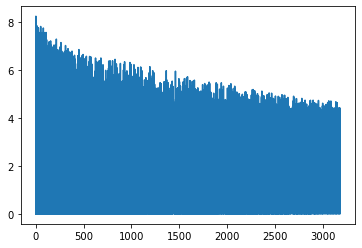

In [13]:
plt.plot([i for i in range(len(losses))], losses)